# Unsupervised Learning using Bayesian Mixture Models

The following tutorial illustrates the use *Turing* for clustering data using a Bayesian mixture model. The aim of this task is to infer a latent grouping (hidden structure) from unlabelled data.

---

More specifically, we are for example interested in discovering the grouping illustrated in figure below. This example consists of 2-D data points, i.e. $\boldsymbol{x} = \{x_i\}_{i=1}^N \,, x_i \in \mathcal{R}^2$, which are distributed according to Gaussian distributions.

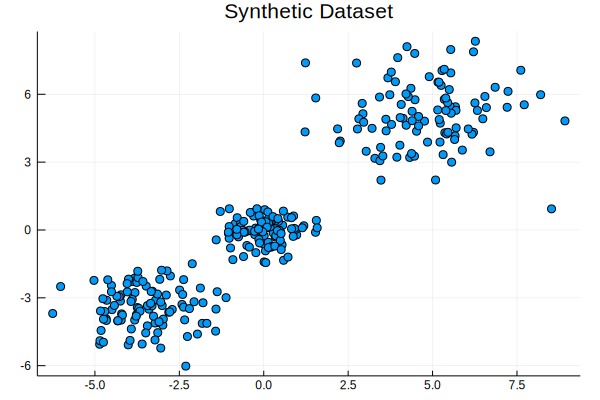

In [111]:
using Distributions, StatPlots, Random

# Set a random seed.
Random.seed!(3)

# Construct 100 data points for each cluster.
N = 100

# Parameters for each cluster, we assume that each cluster is Gaussian distributed in the example.
μs = [-3.5, 0.0, 5.0]
σs = [1.0, 0.6, 1.5]

# Construct the data points.
x = mapreduce(c -> rand(MvNormal([μs[c], μs[c]], σs[c]), N), hcat, 1:3)

# Visualization.
scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

## Gaussian Mixture Model in Turing

To cluster the data points shown above, we use a model that consists of three mixture components (clusters) and assigns each datum to one of the components. The assignment thereof determines the distribution that the data point is generated from.

---

In particular, in a Bayesian Gaussian mixture model with $1 \leq k \leq K$ components for 1-D data each data point $x_i$ with $1 \leq i \leq N$ is generated according to the following generative process.
First we draw the parameters for each cluster, i.e.

$$
\mu_k \sim Normal() \, , \;  \forall k \\
\sigma_k \sim InverseGamma(a, b) \, , \;  \forall k \\
$$
and then draw mixing weight for the $K$ clusters from a Dirichlet distribution, i.e.

$$
    w \sim Dirichlet(K, \alpha) \, . \\
$$
After having constructed all the necessary model parameters, we can generate an observation by first selecting one of the clusters and then drawing the datum accordingly, i.e.
$$
    z_i \sim Categorical(w) \, , \;  \forall i \\
    x_i \sim Normal(\mu_{z_i}, \sigma_{z_i}) \, , \;  \forall i
$$

This whole process can be written in a convenient way using Turing.

In [121]:
using Turing, MCMCChain

In [117]:
@model GaussianMixtureModel(x, a, b, α, C, N) = begin
    
    # Draw the paramters for each cluster.
    
    # cluster 1
    μ1 ~ Normal()
    σ1 ~ InverseGamma(a, b)
    
    # cluster 2
    μ2 ~ Normal()
    σ2 ~ InverseGamma(a, b)
    
    # cluster 3
    μ3 ~ Normal()
    σ3 ~ InverseGamma(a, b)
    
    μ = [μ1, μ2, μ3]
    σ = [σ1, σ2, σ3]
    
    
    # Draw weights for the K clusters from a Dirichlet distribution.
    w ~ Dirichlet(C, α)
    
    # Draw assignments for each datum and generate it from a multivariate normal.
    k = zeros(Int, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]]], σ[k[i]])
    end
    return k
end

GaussianMixtureModel (generic function with 7 methods)

In [118]:
Turing.setadbackend(:forward_diff)

:forward_diff

In [157]:
gmm_model = GaussianMixtureModel(x, 1., 1., 1., 3, N*3)
gmm_sampler = Gibbs(1000, PG(1000, 1, :k), HMC(1, 0.05, 10, :w, :μ1, :σ1, :μ2, :σ2, :μ3, :σ3))
tchain = sample(gmm_model, gmm_sampler)

┌ Info:  Assume - `μ1` is a parameter
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:135
┌ Info:  Assume - `σ1` is a parameter
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:135
┌ Info:  Assume - `μ2` is a parameter
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:135
┌ Info:  Assume - `σ2` is a parameter
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:135
┌ Info:  Assume - `μ3` is a parameter
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:135
┌ Info:  Assume - `σ3` is a parameter
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:135
┌ Info:  Assume - `w` is a parameter
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:135
┌ Info:  Assume - `k` is a parameter (ignoring `k` found in global scope)
└ @ Turing /Users/martin/.julia/packages/Turing/hhWPD/src/core/compiler.jl:165
┌ Info:  Observe - `x` is an 

InterruptException: InterruptException:

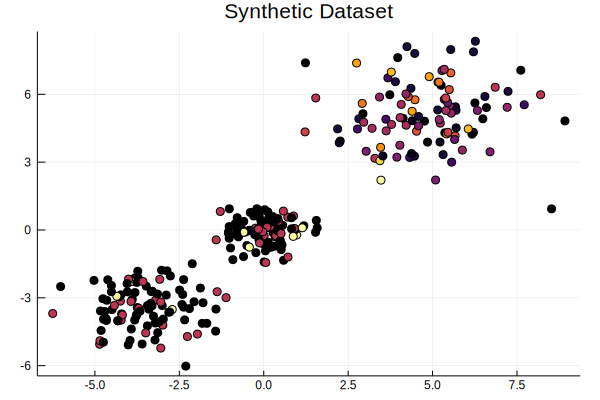

In [156]:
scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset", zcolor = mean(tchain[:k]))